# Artificial Neural Network for Churn Analysis on Bank Customers

## Data preprocessing

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create outputs folder if it doesn't exist
if not os.path.exists('outputs'):
    os.makedirs('outputs')

# Set seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Data Import and Preprocessing
dataset = pd.read_csv('raw_data/Churn_Modelling.csv')
X = dataset.iloc[:, 3:-1].values
y = dataset.iloc[:, -1].values

# Encode gender
le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])

# One Hot encode Geography
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

# Avoid dummy variable trap by removing one dummy variable
X = X[:, 1:]  # Remove the first column to avoid the dummy variable trap

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

## Building the ANN

In [2]:
# Defining the ANN model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 6)
        self.layer2 = nn.Linear(6, 6)
        self.output_layer = nn.Linear(6, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

# Initialize the model
model = ANNModel()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training the ANN

Epoch [10/100], Loss: 0.3881
Epoch [20/100], Loss: 0.3587
Epoch [30/100], Loss: 0.3488
Epoch [40/100], Loss: 0.3447
Epoch [50/100], Loss: 0.3404
Epoch [60/100], Loss: 0.3382
Epoch [70/100], Loss: 0.3367
Epoch [80/100], Loss: 0.3354
Epoch [90/100], Loss: 0.3344
Epoch [100/100], Loss: 0.3336


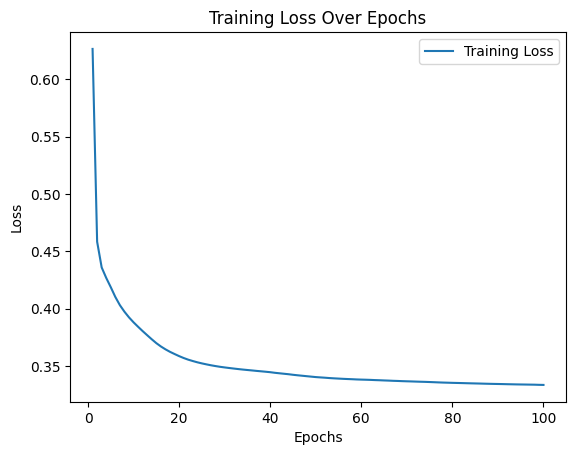

In [3]:
# Training loop
epochs = 100
batch_size = 32
losses = []  # To store the loss at each epoch

def train_model(model, X_train, y_train, epochs, batch_size):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Average loss over batches
        avg_loss = epoch_loss / (len(X_train) / batch_size)
        losses.append(avg_loss)
        
        # Print loss every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

train_model(model, X_train, y_train, epochs, batch_size)

# Plotting training loss over epochs
plt.figure()
plt.plot(range(1, epochs+1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.savefig('outputs/training_loss.png')
plt.show()
plt.close()

## Making the predictions and evaluating the model

Probability of churn: 0.032193172723054886
Churn prediction: False
[[1516   79]
 [ 195  210]]
Accuracy: 0.8630


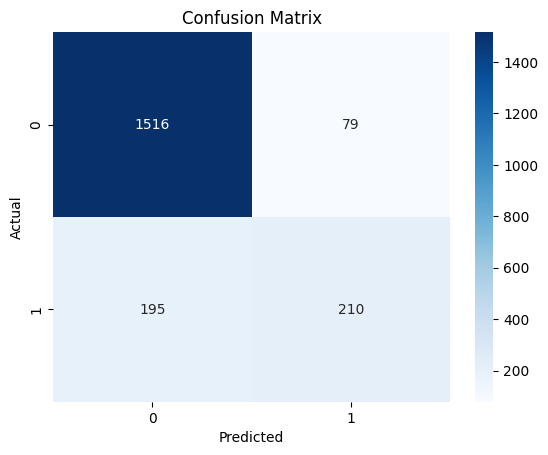

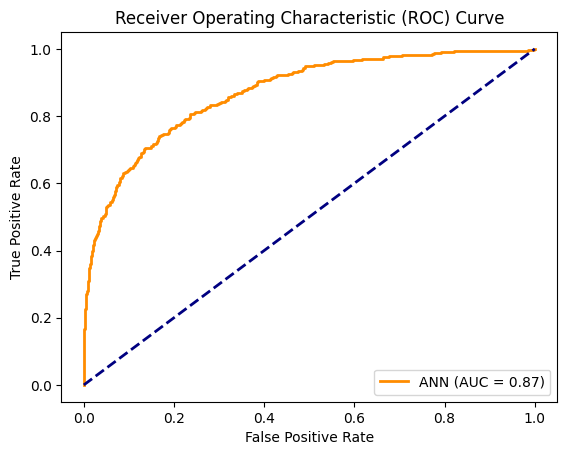

In [8]:
# Predicting churn for a specific customer
# Prepare the input data
sample_data = [[0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]]  # After removing one dummy variable
sample_input = sc.transform(sample_data)
sample_tensor = torch.tensor(sample_input, dtype=torch.float32)
prediction = model(sample_tensor)
print('Probability of churn:', prediction.item())
print('Churn prediction:', prediction.item() > 0.5)

# Predicting for test set
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test).numpy()
y_pred = (y_pred_prob > 0.5)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')

# Plot confusion matrix as heatmap
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('outputs/confusion_matrix.png')
plt.show()
plt.close()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ANN (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('outputs/roc_curve.png')
plt.show()
plt.close()